In [1]:
import os
import re
import numpy as np
import pandas as pd
from collections import defaultdict


folders = [
    r"Results_internal\Evaluated",
    r"Results_external\Evaluated"
]

all_merged_results = []

for folder_path in folders:
    data_by_config = defaultdict(list)
    
    for filename in os.listdir(folder_path):
        if not filename.endswith(".csv"):
            continue
        match = re.search(r"generator_(.*?)_temperature_([\d.]+)(?:_\d+)?\.csv", filename)
        if not match:
            print('something wrong')
            continue
        generator = match.group(1)
        temperature = float(match.group(2))
        key = (generator, temperature)
        
        filepath = os.path.join(folder_path, filename)
        df = pd.read_csv(filepath)
        required_cols = {'book_title', 'score_gemini', 'score_gpt'}
        if not required_cols.issubset(df.columns):
            print('required columns do not exist')
            continue
        data_by_config[key].append(df)
    
    merged_results = {}
    for key, df_list in data_by_config.items():
        merged_df = pd.concat(df_list, ignore_index=True)
        stats_df = merged_df.groupby('book_title')[['score_gemini', 'score_gpt']].agg(['mean','std'])
        stats_df.columns = [f"{col}_{stat}" for col, stat in stats_df.columns]
        stats_df = stats_df.reset_index()
        overall_avg = {
            "score_gemini_mean": stats_df['score_gemini_mean'].mean(),
            "score_gemini_std": stats_df['score_gemini_mean'].std(),
            "score_gpt_mean": stats_df['score_gpt_mean'].mean(),
            "score_gpt_std": stats_df['score_gpt_mean'].std()
        }
        merged_results[key] = {
            "stats_per_book": stats_df,
            "overall_avg": overall_avg
        }
    
    all_merged_results.append(merged_results)

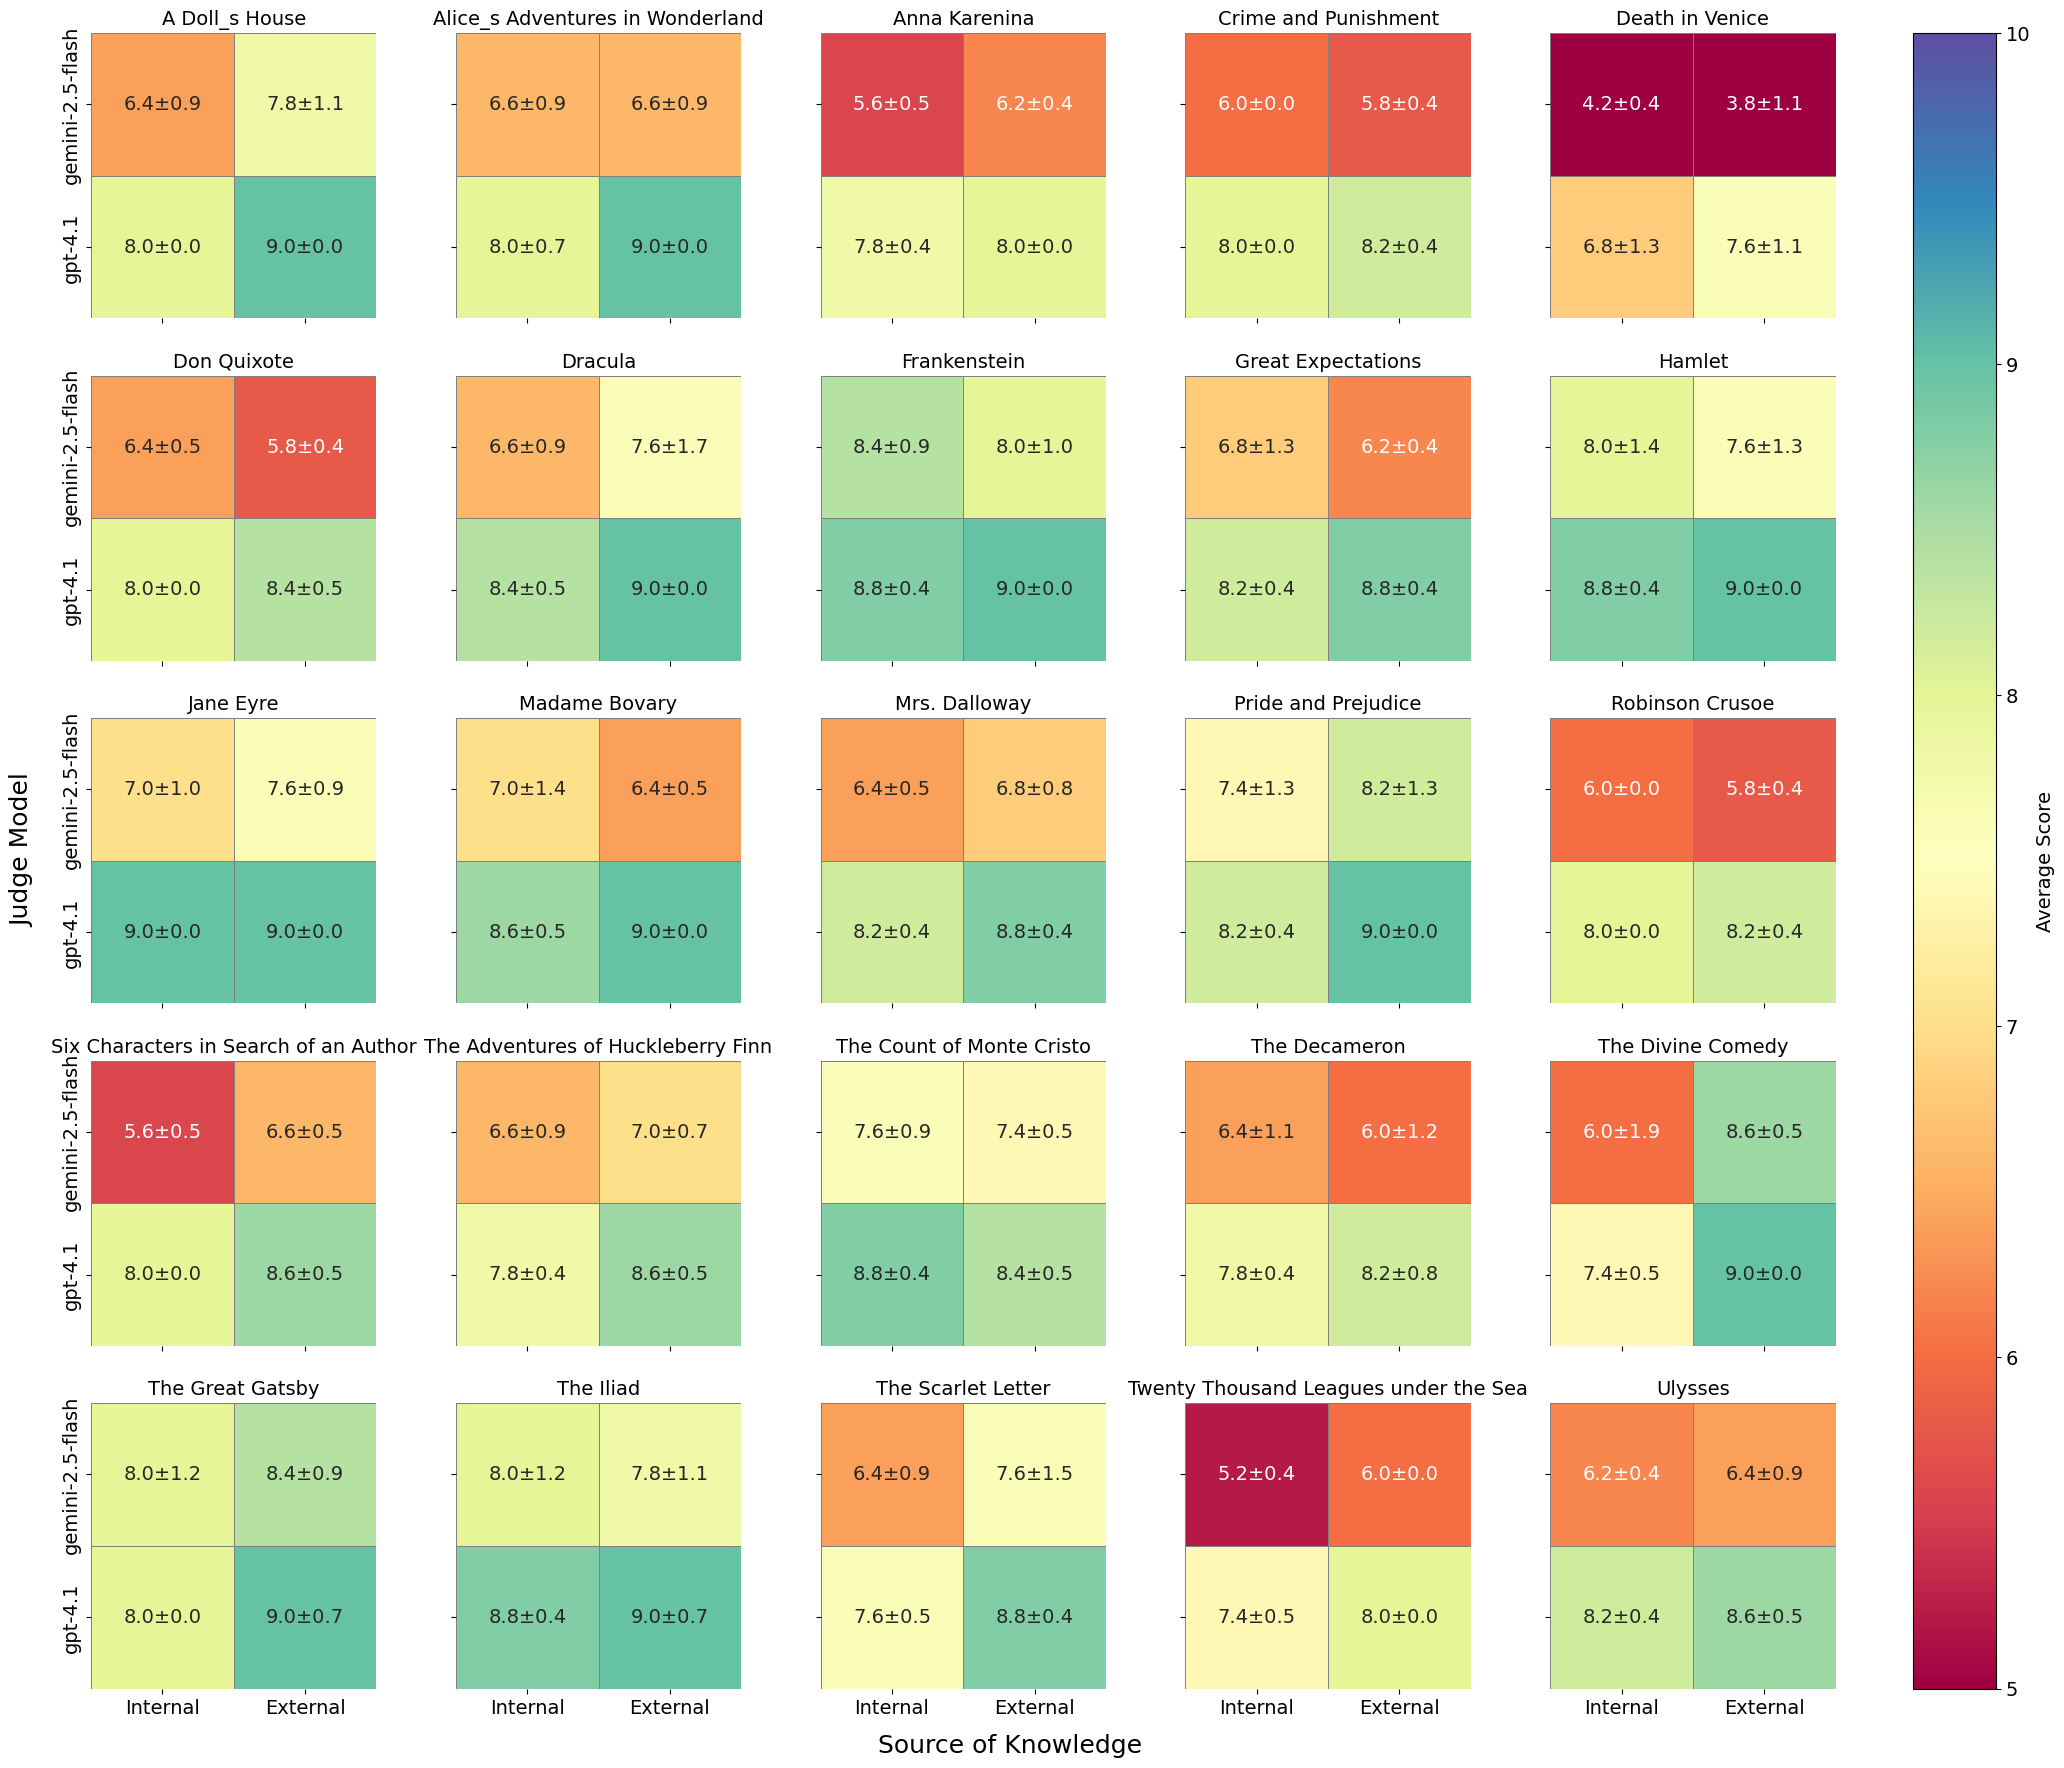

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

generator_to_plot = "gpt-4.1"
temperature = 0.4
judges = ["gemini-2.5-flash", "gpt-4.1"]
folders_labels = ["Internal", "External"]

book_titles = all_merged_results[0][(generator_to_plot, temperature)]["stats_per_book"]["book_title"].tolist()

cols = 5
rows = int(np.ceil(len(book_titles)/cols))
fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 4.3*rows))
axes = axes.flatten()
vmin, vmax = 5, 10
fontsize = 14

for i, book in enumerate(book_titles):
    matrix = np.zeros((len(judges), len(folders)))
    annot_matrix = np.empty((len(judges), len(folders)), dtype=object)
    
    for f_idx, merged_results in enumerate(all_merged_results):
        key = (generator_to_plot, temperature)
        if key in merged_results:
            df = merged_results[key]["stats_per_book"]
            score_row = df[df["book_title"] == book]
            if not score_row.empty:

                matrix[0, f_idx] = score_row["score_gemini_mean"].values[0]
                matrix[1, f_idx] = score_row["score_gpt_mean"].values[0]
                annot_matrix[0, f_idx] = f"{score_row['score_gemini_mean'].values[0]:.1f}±{score_row['score_gemini_std'].values[0]:.1f}"
                annot_matrix[1, f_idx] = f"{score_row['score_gpt_mean'].values[0]:.1f}±{score_row['score_gpt_std'].values[0]:.1f}"
    
    df_matrix = pd.DataFrame(matrix, index=judges, columns=folders_labels)
    sns.heatmap(df_matrix, annot=annot_matrix, fmt='', cmap="Spectral",
                cbar=False, vmin=vmin, vmax=vmax, 
                linewidths=0.5, linecolor="gray", 
                ax=axes[i], square=True, annot_kws={"size": fontsize})
    axes[i].set_title(book.split("-")[0], fontsize=fontsize)

for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])


fig.text(0.5, 0.08, "Source of Knowledge", ha='center', fontsize=fontsize+4)
fig.text(0.1, 0.5, "Judge Model", va='center', rotation='vertical', fontsize=fontsize+4)
for i, ax in enumerate(axes):
    row, col = divmod(i, cols)
    if col != 0: 
        ax.set_ylabel("")
        ax.set_yticklabels([])
    else: 
        ax.tick_params(axis='y', labelsize=fontsize)
    if row != rows - 1: 
        ax.set_xlabel("")
        ax.set_xticklabels([])
    else: 
        ax.tick_params(axis='x', labelsize=fontsize)
# colorbar
sm = plt.cm.ScalarMappable(cmap="Spectral", norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.05, pad=0.04)
cbar.set_label("Average Score", fontsize=fontsize)
cbar.ax.tick_params(labelsize=fontsize)

plt.savefig(f'Figures/compare_{generator_to_plot}_{temperature}.png', dpi=300, bbox_inches='tight')
plt.show()


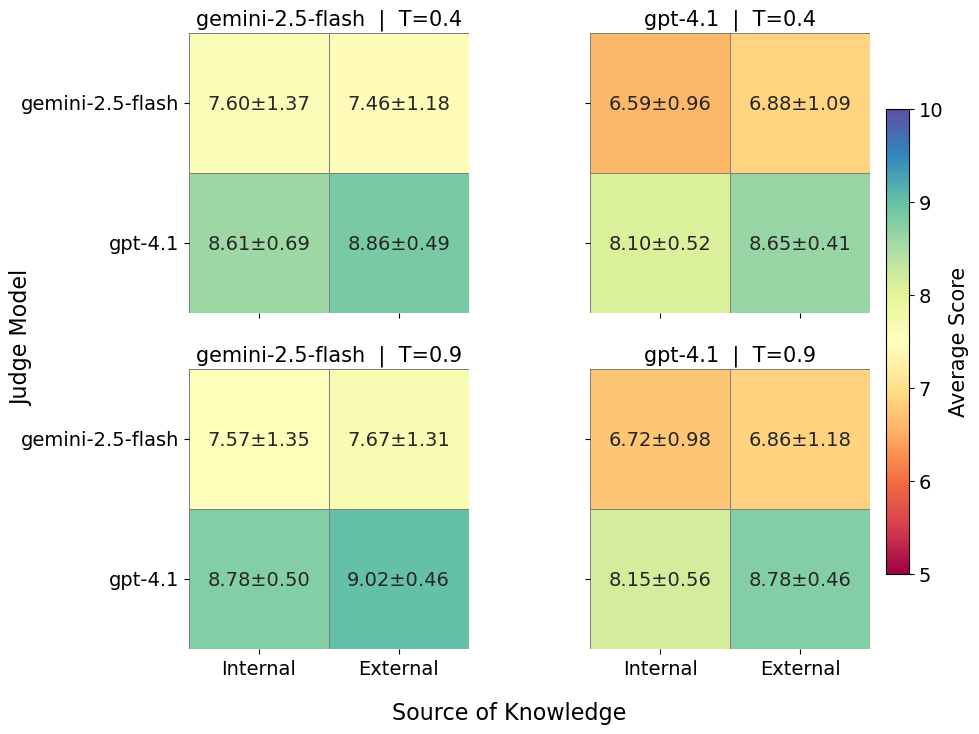

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


folders_labels = ["Internal", "External"]  

generators = ["gemini-2.5-flash", "gpt-4.1"]
judges = ["gemini-2.5-flash", "gpt-4.1"]
temperatures = [0.4, 0.9]
fontsize = 14
vmin, vmax = 5, 10
cmap = "Spectral"
norm = plt.Normalize(vmin=vmin, vmax=vmax)


fig, axes = plt.subplots(
    nrows=len(temperatures), 
    ncols=len(generators), 
    figsize=(5 * len(generators), 4 * len(temperatures)),
    squeeze=False,  # 保证 axes[row][col] 总是可索引
    sharex=True,
    sharey=True
)


judge_to_mean_key = {
    "gemini-2.5-flash": "score_gemini_mean",
    "gpt-4.1": "score_gpt_mean"
}
judge_to_std_key = {
    "gemini-2.5-flash": "score_gemini_std",
    "gpt-4.1": "score_gpt_std"
}

for row_idx, temperature in enumerate(temperatures):
    for col_idx, generator in enumerate(generators):

        df_mean = pd.DataFrame(index=judges, columns=folders_labels, dtype=float)
        df_std  = pd.DataFrame(index=judges, columns=folders_labels, dtype=float)


        for folder_idx, folder_label in enumerate(folders_labels):
            merged_results = all_merged_results[folder_idx]
            key = (generator, temperature)
            if key not in merged_results:

                print(f"Warning: key {key} not found in folder '{folder_label}'. Leaving NaNs.")
                continue
            overall_avg = merged_results[key]["overall_avg"]


            for judge in judges:
                mean_key = judge_to_mean_key.get(judge)
                std_key  = judge_to_std_key.get(judge)

                if mean_key in overall_avg:
                    df_mean.loc[judge, folder_label] = overall_avg[mean_key]
                if std_key in overall_avg:
                    df_std.loc[judge, folder_label] = overall_avg[std_key]


        annot_matrix = df_mean.copy().astype(object)
        for r in range(len(judges)):
            for c in range(len(folders_labels)):
                mean_val = df_mean.iloc[r, c]
                std_val  = df_std.iloc[r, c]
                if pd.notna(mean_val):

                    if pd.notna(std_val):
                        annot_matrix.iloc[r, c] = f"{mean_val:.2f}±{std_val:.2f}"
                    else:
                        annot_matrix.iloc[r, c] = f"{mean_val:.2f}"
                else:
                    annot_matrix.iloc[r, c] = ""


        ax = axes[row_idx][col_idx]
        sns.heatmap(
            df_mean,
            annot=annot_matrix,
            fmt='',
            cmap=cmap,
            cbar=False,
            linewidths=0.5,
            linecolor="gray",
            ax=ax,
            square=True,
            annot_kws={"size": fontsize},
            vmin=vmin,
            vmax=vmax
        )


        ax.set_title(f"{generator}  |  T={temperature}", fontsize=fontsize+1)
        
        if col_idx == 0:
            ax.set_ylabel("", fontsize=fontsize)
        else:
            ax.set_ylabel("")
        if row_idx == 1:
            ax.set_xlabel("", fontsize=fontsize)
        ax.tick_params(axis='x', rotation=0, labelsize=fontsize)
        ax.tick_params(axis='y', rotation=0, labelsize=fontsize)

fig.text(0.5, 0.023, "Source of Knowledge", ha='center', fontsize=fontsize+2)
fig.text(0.001, 0.5, "Judge Model", va='center', rotation='vertical', fontsize=fontsize+2)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.03, pad=0.02)
cbar.set_label("Average Score", fontsize=fontsize+1)
cbar.ax.tick_params(labelsize=fontsize)

# fig.suptitle("Performance Heatmaps (rows=temperature, cols=generator)", fontsize=fontsize+4, y=1.02)
# plt.tight_layout()
plt.savefig('Figures/ALL_generators_temperatures_heatmaps.png', dpi=300, bbox_inches='tight')
plt.show()


In [2]:
book_list = ['Pride and Prejudice','The Decameron','The Divine Comedy','Jane Eyre','Alice\'s Adventures in Wonderland','Don Quixote','Great Expectations','Robinson Crusoe','Crime and Punishment','The Count of Monte Cristo','The Great Gatsby','Madame Bovary','The Scarlet Letter','The Iliad','A Doll\'s House','Ulysses','Six Characters in Search of an Author','Hamlet','Frankenstein','Dracula','Anna Karenina','The Adventures of Huckleberry Finn','20,000 Leagues Under the Sea','Mrs. Dalloway','Death in Venice']

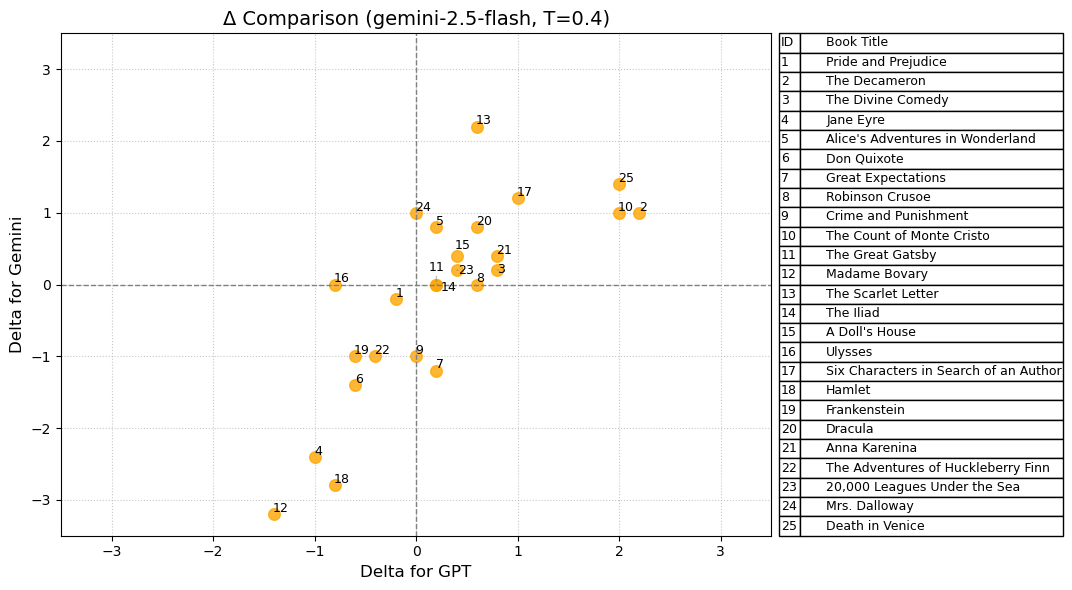

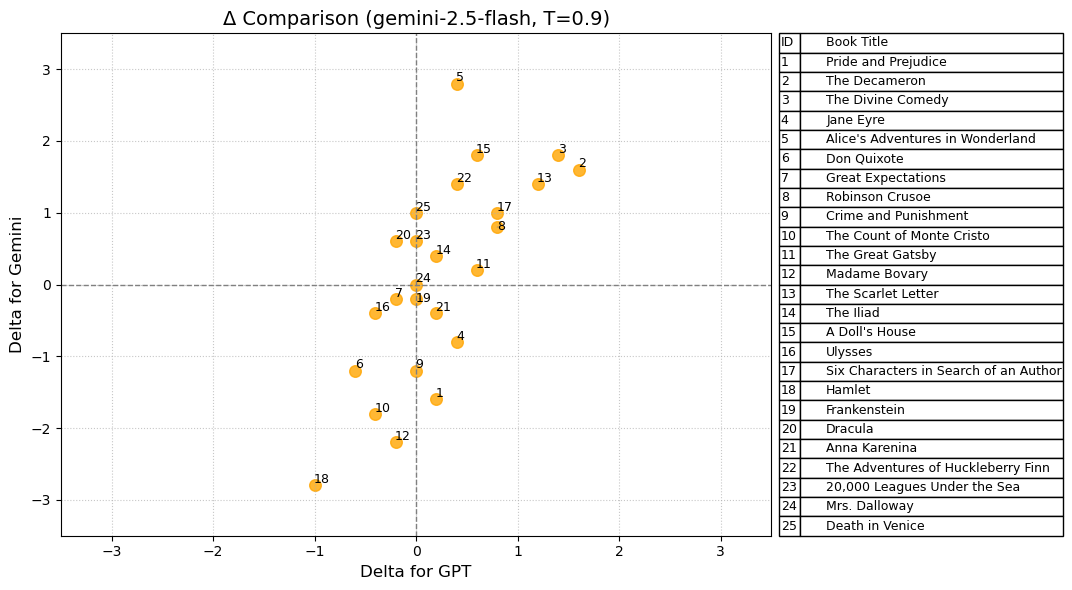

7 [-0.40341815  0.30743396]
8 [-0.06910492  0.4506287 ]
17 [-0.33784664 -0.58487159]
18 [0.23719941 0.20743704]
16 [0.70131206 0.10562421]
19 [-0.03200734  0.15260678]


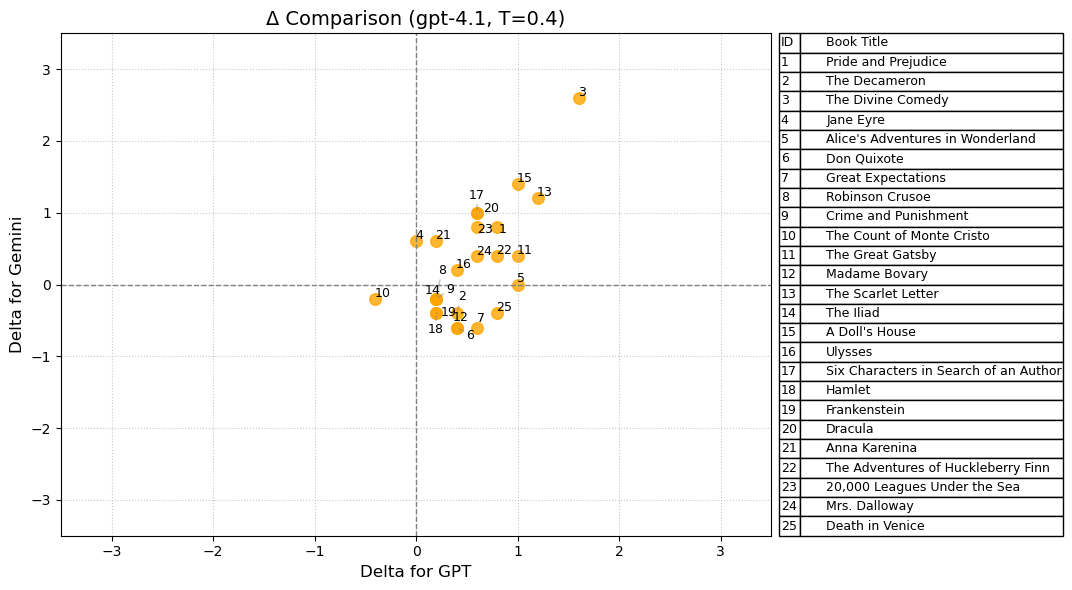

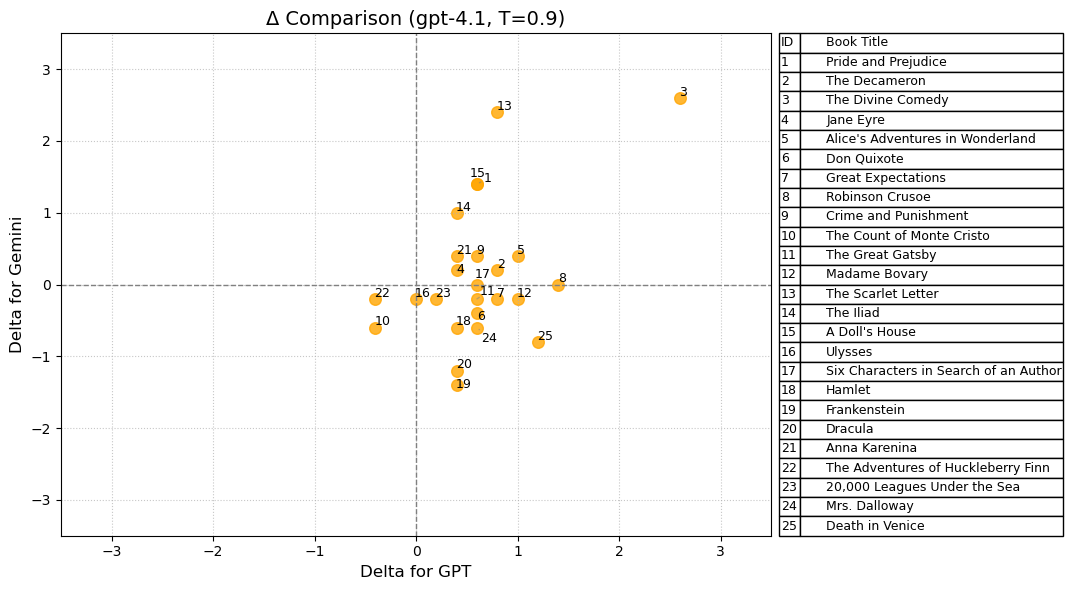

In [38]:
import matplotlib.pyplot as plt
from adjustText import adjust_text


internal_results = all_merged_results[0]
external_results = all_merged_results[1]

generators = ["gemini-2.5-flash", "gpt-4.1"]
temperatures = [0.4, 0.9]

for generator in generators:
    for temperature in temperatures:
        key = (generator, temperature)
        
        if key not in internal_results or key not in external_results:
            print(f"Skipping {key} (missing data)")
            continue
        
        df_int = internal_results[key]["stats_per_book"]
        df_ext = external_results[key]["stats_per_book"]
    
        merged = pd.merge(df_int, df_ext, on="book_title", suffixes=("_int", "_ext"))
        
        merged["delta_gemini"] = merged["score_gemini_mean_ext"] - merged["score_gemini_mean_int"]
        merged["delta_gpt"] = merged["score_gpt_mean_ext"] - merged["score_gpt_mean_int"]
        
        merged["book_title_clean"] = merged["book_title"].str.split("-", n=1).str[0]
        merged["book_title_clean"] = merged["book_title_clean"].str.replace("_", "'", regex=False)
        merged["book_title_clean"] = merged["book_title_clean"].str.replace(
            "Twenty Thousand Leagues under the Sea", "20,000 Leagues Under the Sea", regex=False
        )
        ordered_rows = []
        for idx, title in enumerate(book_list, start=1):
            row = merged[merged["book_title_clean"] == title]
            if not row.empty:
                row = row.copy()
                row["book_id"] = idx
                ordered_rows.append(row)
            else:
                print(title)
                print('###########################################')
        
        if not ordered_rows:
            print(f"No valid books found for {generator} @ T={temperature}")
            continue
        
        merged_ordered = pd.concat(ordered_rows, ignore_index=True)
        

        plt.figure(figsize=(11.6, 6))
        plt.xlim(-3.5, 3.5)
        plt.ylim(-3.5, 3.5)
        
        plt.scatter(merged_ordered["delta_gpt"], merged_ordered["delta_gemini"], s=70, c='orange', alpha=0.8)
        
        # 标上编号
        texts = []
        for _, row in merged_ordered.iterrows():
            texts.append(
                plt.text(row["delta_gpt"], row["delta_gemini"], str(row["book_id"]), fontsize=9)
            )
        adjust_text(texts, 
            arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5))
        plt.axhline(0, color="gray", linestyle="--", linewidth=1)
        plt.axvline(0, color="gray", linestyle="--", linewidth=1)
        
        plt.title(f"Δ Comparison ({generator}, T={temperature})", fontsize=14)
        plt.xlabel("Delta for GPT", fontsize=12)
        plt.ylabel("Delta for Gemini", fontsize=12)
        plt.grid(True, linestyle=":", alpha=0.7)
        
        
        table_data = [[idx+1, title] for idx, title in enumerate(book_list)]

        table = plt.table(
            cellText=table_data,
            colLabels=['ID', 'Book Title'],
            colWidths=[0.03, 0.37],
            cellLoc='left',
            loc='center',
            bbox=[1.01, 0., 0.4, 1]
        )
        
        for key, cell in table.get_celld().items():
            cell.get_text().set_ha('left')
            cell.get_text().set_position((0.02, 0.5))
            
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.2)
        plt.tight_layout()
        plt.savefig(f'Figures/Delta_Comparison_{generator}_T{temperature}.png', dpi=300, bbox_inches='tight')

        plt.show()

